In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"    

In [3]:
dataset=np.load('wav16.npz')

In [4]:
#dataset.files

In [5]:
#len(dataset['fold1'].item().get('sounds'))

# Dataset preparation

Splitting the dataset into train & validation set

In [39]:
#dataset = np.load('data_dl/ESC-50-master/audio_resampled/wav_complete.npz')
split=3
# Split to train and val
train_sounds = []
train_labels = []
val_sounds = []
val_labels = []
for i in range(1, 6):
    sounds = dataset['fold{}'.format(i)].item()['sounds']
    labels = dataset['fold{}'.format(i)].item()['labels']
    if i == split:
        val_sounds.extend(sounds)
        val_labels.extend(labels)
    else:
        train_sounds.extend(sounds)
        train_labels.extend(labels)

In [7]:
#name={'crying_baby':0, 'glass_breaking':1, 'coughing':2}
#train_labels=list(map(name.get, train_labels))
#val_labels=list(map(name.get, val_labels))

In [8]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [9]:
train_labels=one_hot_encode(train_labels)
val_labels=one_hot_encode(val_labels)

Normalize to have value between -1 and 1

In [10]:
def normalize(sound, factor=32768):
    return [s/factor for s in sound]

Random crop of the sound values to have T-s window of sound

In [11]:
def random_crop(sound, size=24014):
    cropped_sound=[]
    for s in sound:
        org_size = len(s)
        start = random.randint(0, org_size - size)
        cropped_s=s[start: start + size]
        cropped_sound.append(cropped_s)
    return cropped_sound

In [12]:
def padding(sound, pad=24014//2):
    if len(sound)<80000:
        padded_sound=[]
        for i in range(len(sound)):
            padded_s=np.pad(sound[i], pad, 'constant')
            padded_sound.append(padded_s)
    return padded_sound

Multi-crop for testing phase

In [13]:
def multi_crop(sounds,input_length=24014, n_crops=10):
    multi_cropped_sounds=[]
    for s in sounds:
        stride = (len(s) - input_length) // (n_crops - 1)
        multi_cropped_sound = [s[stride * i: stride * i + input_length] for i in range(n_crops)]
        multi_cropped_sounds.append(np.array(multi_cropped_sound))
    return multi_cropped_sounds

In [14]:
# what is supposed to be the pad parameter ?
#train_sounds=padding(train_sounds, 24014//2) 
#val_sounds=padding(train_sounds, 24014//2)

Size of window = 1.5s (24014)

Normalization constant = 32768 

In [15]:
train_y=train_labels

In [16]:
test_X=multi_crop(normalize(padding(val_sounds)))

In [17]:
test_X = np.reshape(test_X, (-1, 24014, 1, 1))

In [18]:
test_X.shape

(4000, 24014, 1, 1)

In [19]:
test_y=np.repeat(val_labels, 10, axis=0)
test_y.shape

(4000, 50)

In [20]:
#test_y=val_labels

To improve : do the cross validation

# Model

In [21]:
import tensorflow as tf

In [22]:
#n_classes=3
n_classes=50 

## Input of the model

Recall that the tensor is 4D : [batch, height, width, channel]

In [23]:
X = tf.placeholder(tf.float32, shape=[None, 24014,1, 1])
y = tf.placeholder(tf.float32, shape=[None, n_classes])

In [24]:
keep_prob = tf.placeholder(tf.float32) # 50%

In [25]:
is_training = tf.placeholder(tf.bool)

## Hyperparameters

In [26]:
training_epoch = 300 
batch_size = 64
learning_rate = tf.placeholder(tf.float32)
crop_size=10

In [27]:
def lr(epoch):
    if (0<=epoch<=80):
        return 0.01
    if (80<epoch<=100):
        return 0.001
    if (100<epoch<= 120):
        return 0.0001
    else: return 0.00001

Stride =1

No Padding

In [28]:
def conv2d(x, W, b,is_training, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    x = tf.contrib.layers.batch_norm(x, is_training=is_training)
    return tf.nn.relu(x) 

def maxpool2d(x, k_h=2, k_w=2):
    return tf.nn.max_pool(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1],padding='VALID')

## Parameters of the model

Initialization of the parameters = He initialization

Review the order (does the order actually matters ?)

[heigth_filter, width_filter, depth_filter, number of filters]

In [29]:
weights = {
    #conv1
    'wc1': tf.get_variable('W0', shape=(8,1,1,40), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv2
    'wc2': tf.get_variable('W1', shape=(8,1,40,40), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv3
    'wc3': tf.get_variable('W2', shape=(13,8,1,50), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv4
    'wc4': tf.get_variable('W3', shape=(5,1,50,50), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #fc5
    'wfc5': tf.get_variable('W4', shape=(50*11*14,4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #fc5
    'wfc6': tf.get_variable('W5', shape=(4096,4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #output
    'out': tf.get_variable('W6', shape=(4096,n_classes), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(40), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc2': tf.get_variable('B1', shape=(40), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc3': tf.get_variable('B2', shape=(50), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc4': tf.get_variable('B3', shape=(50), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bfc5': tf.get_variable('B4', shape=(4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bfc6': tf.get_variable('B5', shape=(4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'out': tf.get_variable('B6', shape=(n_classes), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
}

## EnvNet

In [30]:
def env_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'], is_training)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], is_training)
    conv2 = maxpool2d(conv2, k_h=160, k_w=1)
    
    conv2=tf.reshape(conv2, [-1, 150, 40, 1])
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], is_training)
    conv3 = maxpool2d(conv3, k_h=3, k_w=3)
    
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'], is_training)
    conv4 = maxpool2d(conv4, k_h=3, k_w=1)
    
    # Fully connected layer
    fc5 = tf.reshape(conv4, [-1, weights['wfc5'].get_shape().as_list()[0]])
    fc5 = tf.add(tf.matmul(fc5, weights['wfc5']), biases['bfc5'])
    fc5 = tf.nn.relu(fc5)
    # Drop out
    drop_out_fc5 = tf.nn.dropout(fc5, keep_prob)
    
    fc6 = tf.add(tf.matmul(drop_out_fc5, weights['wfc6']), biases['bfc6'])
    fc6 = tf.nn.relu(fc6)
    drop_out_fc6 = tf.nn.dropout(fc6, keep_prob)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(drop_out_fc6, weights['out']), biases['out'])
    return out

## Loss & optimizer of the model

In [31]:
init_momentum = 0.9
momentum = tf.Variable(init_momentum, trainable=False)

In [32]:
logits = env_net(X, weights, biases)

pred_train=logits

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_train, labels=y))

pred_test=tf.reduce_sum(tf.nn.softmax(logits),0)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True).minimize(cost)

In [33]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
#correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

correct_prediction_train = tf.equal(tf.argmax(pred_train, 1), tf.argmax(y, 1))
correct_prediction_test = tf.equal(tf.argmax(pred_test, 0), tf.argmax(y, 1)[0])

#calculate accuracy across all the given images and average them out. 
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32))
accuracy_test=tf.cast(correct_prediction_test, tf.float32)

In [34]:
# Initializing the variables
init = tf.global_variables_initializer()

In [35]:
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        sess.run(init) 
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []
        summary_writer = tf.summary.FileWriter('./Output', sess.graph)
        for i in range(training_epoch):
            train_X=random_crop(normalize(padding(train_sounds))) # Choosing randomly a 1.5s section
            train_X = np.reshape(train_X, (-1, 24014, 1, 1)) # Reshape to have 1D input
            for batch in range(len(train_X)//batch_size):
                batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
                batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
                    # Run optimization op (backprop).
                        # Calculate batch loss and accuracy
                opt = sess.run(optimizer, feed_dict={X: batch_x, y: batch_y, 
                                                         keep_prob:0.5, is_training:True, 
                                                         learning_rate:lr(i)})
                loss, acc = sess.run([cost, accuracy_train], feed_dict={X: batch_x, y: batch_y, 
                                                                         keep_prob:0.5, is_training:True,
                                                                     learning_rate:lr(i)})
            print("Iter " + str(i) + ", Loss= " + \
                              "{:.6f}".format(loss) + ", Training Accuracy= " + \
                              "{:.5f}".format(acc))
            print("Optimization Finished!")
            
            acc_test=[]
            for crop in range(len(test_X)//crop_size):
                crop_x = test_X[crop*crop_size:min((crop+1)*crop_size,len(test_X))]
                crop_y = test_y[crop*crop_size:min((crop+1)*crop_size,len(test_y))] 
                
                acc_t= sess.run([accuracy_test], feed_dict={X: crop_x, y : crop_y, 
                                                                           keep_prob:1.0, is_training:False,
                                                            learning_rate:lr(i)})
                acc_test.append(acc_t)
               
            test_acc=np.mean(acc_test)
            #print(len(acc_test))
            
            train_loss.append(loss)
            #test_loss.append(valid_loss)
            train_accuracy.append(acc)
            test_accuracy.append(test_acc)
            print("Testing Accuracy:","{:.5f}".format(test_acc))
        summary_writer.close()

Iter 0, Loss= 4.192940, Training Accuracy= 0.01562
Optimization Finished!
Testing Accuracy: 0.01500
Iter 1, Loss= 3.853369, Training Accuracy= 0.04688
Optimization Finished!
Testing Accuracy: 0.02250
Iter 2, Loss= 3.852890, Training Accuracy= 0.04688
Optimization Finished!
Testing Accuracy: 0.02500
Iter 3, Loss= 3.703879, Training Accuracy= 0.10938
Optimization Finished!
Testing Accuracy: 0.03250
Iter 4, Loss= 3.705049, Training Accuracy= 0.07812
Optimization Finished!
Testing Accuracy: 0.04000
Iter 5, Loss= 3.601861, Training Accuracy= 0.12500
Optimization Finished!
Testing Accuracy: 0.05750
Iter 6, Loss= 3.487177, Training Accuracy= 0.07812
Optimization Finished!
Testing Accuracy: 0.06500
Iter 7, Loss= 3.314870, Training Accuracy= 0.12500
Optimization Finished!
Testing Accuracy: 0.05500
Iter 8, Loss= 3.278057, Training Accuracy= 0.17188
Optimization Finished!
Testing Accuracy: 0.04500
Iter 9, Loss= 3.277998, Training Accuracy= 0.07812
Optimization Finished!
Testing Accuracy: 0.06000


Testing Accuracy: 0.09000
Iter 82, Loss= 1.522432, Training Accuracy= 0.59375
Optimization Finished!
Testing Accuracy: 0.10500
Iter 83, Loss= 1.362282, Training Accuracy= 0.56250
Optimization Finished!
Testing Accuracy: 0.10500
Iter 84, Loss= 1.306241, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.10750
Iter 85, Loss= 1.417763, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.09500
Iter 86, Loss= 1.343283, Training Accuracy= 0.53125
Optimization Finished!
Testing Accuracy: 0.11500
Iter 87, Loss= 1.351031, Training Accuracy= 0.60938
Optimization Finished!
Testing Accuracy: 0.11500
Iter 88, Loss= 0.980640, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.12000
Iter 89, Loss= 1.248711, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.12250
Iter 90, Loss= 1.319393, Training Accuracy= 0.62500
Optimization Finished!
Testing Accuracy: 0.12750
Iter 91, Loss= 1.203843, Training Accuracy= 0.65625
Optimization 

Testing Accuracy: 0.43000
Iter 163, Loss= 1.220673, Training Accuracy= 0.71875
Optimization Finished!
Testing Accuracy: 0.43000
Iter 164, Loss= 1.492281, Training Accuracy= 0.59375
Optimization Finished!
Testing Accuracy: 0.42750
Iter 165, Loss= 1.351934, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.42750
Iter 166, Loss= 1.167603, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.42750
Iter 167, Loss= 1.163101, Training Accuracy= 0.70312
Optimization Finished!
Testing Accuracy: 0.42750
Iter 168, Loss= 1.216081, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.43500
Iter 169, Loss= 1.255648, Training Accuracy= 0.56250
Optimization Finished!
Testing Accuracy: 0.44000
Iter 170, Loss= 1.360895, Training Accuracy= 0.60938
Optimization Finished!
Testing Accuracy: 0.44000
Iter 171, Loss= 1.021326, Training Accuracy= 0.70312
Optimization Finished!
Testing Accuracy: 0.44250
Iter 172, Loss= 1.305650, Training Accuracy= 0.54688
Opt

Testing Accuracy: 0.54000
Iter 244, Loss= 1.286838, Training Accuracy= 0.64062
Optimization Finished!
Testing Accuracy: 0.54000
Iter 245, Loss= 1.007021, Training Accuracy= 0.68750
Optimization Finished!
Testing Accuracy: 0.53750
Iter 246, Loss= 1.165454, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.54000
Iter 247, Loss= 1.197924, Training Accuracy= 0.65625
Optimization Finished!
Testing Accuracy: 0.54000
Iter 248, Loss= 1.183702, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.54000
Iter 249, Loss= 1.239195, Training Accuracy= 0.60938
Optimization Finished!
Testing Accuracy: 0.54000
Iter 250, Loss= 1.050368, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.54000
Iter 251, Loss= 1.139124, Training Accuracy= 0.64062
Optimization Finished!
Testing Accuracy: 0.54000
Iter 252, Loss= 1.275778, Training Accuracy= 0.59375
Optimization Finished!
Testing Accuracy: 0.54000
Iter 253, Loss= 1.276799, Training Accuracy= 0.62500
Opt

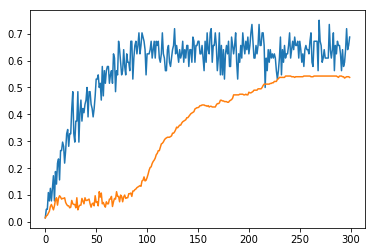

In [38]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)

TO DO/REMARKS : 
- Accuracy for now : 0.2950 (with my dataset), 0.35750 (with their dataset)
- With only 3 classes (baby crying, glass breaking, coughing) : 0.6250 
- why is training accuracy low ?
- check for silent windows -> remove them
- why 10 crops for testing phase ?
- Accuracy with the new testing scheme + 150 training epochs : 0.365 (with my dataset), 0.48 (with their dataset)
- 230 traning epochs, testing accuracy : 0.54
- Test on another dataset
- Semi-supervised learning ?
- Check to remove silent windows in test set ?